Importing Libraries 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Data Augmentation 

In [2]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


Load the datasets

In [3]:

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:33<00:00, 5.10MB/s] 


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN8Layer(nn.Module):
    def __init__(self):
        super(CNN8Layer, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    # Layer 1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # Layer 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Layer 3
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 128, kernel_size=3, padding=1), # Layer 4
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Layer 5
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),                   # Layer 6
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),                           # Layer 7
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 10)                             # Layer 8
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Train the Model

In [5]:
import torch
import copy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, patience=3):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss_epoch = total_loss / len(train_loader)
        train_acc_epoch = 100 * correct / total
        train_loss.append(train_loss_epoch)
        train_acc.append(train_acc_epoch)

        val_l, val_a = evaluate(model, val_loader, criterion, device)
        val_loss.append(val_l)
        val_acc.append(val_a)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc_epoch:.2f}% | "
              f"Val Loss: {val_l:.4f} | Val Acc: {val_a:.2f}%")

        # Early Stopping Check
        if val_l < best_val_loss:
            best_val_loss = val_l
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN8Layer().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    epochs=20, patience=4
)


Epoch [1/20] Train Loss: 1.8939 | Train Acc: 26.70% | Val Loss: 1.6516 | Val Acc: 37.18%
Epoch [2/20] Train Loss: 1.6099 | Train Acc: 39.49% | Val Loss: 1.4666 | Val Acc: 47.30%
Epoch [3/20] Train Loss: 1.4839 | Train Acc: 46.01% | Val Loss: 1.3458 | Val Acc: 51.84%
Epoch [4/20] Train Loss: 1.3913 | Train Acc: 50.16% | Val Loss: 1.2159 | Val Acc: 56.06%
Epoch [5/20] Train Loss: 1.3243 | Train Acc: 53.42% | Val Loss: 1.1320 | Val Acc: 60.28%
Epoch [6/20] Train Loss: 1.2731 | Train Acc: 55.30% | Val Loss: 1.1514 | Val Acc: 58.06%
Epoch [7/20] Train Loss: 1.2339 | Train Acc: 57.37% | Val Loss: 1.0875 | Val Acc: 62.18%
Epoch [8/20] Train Loss: 1.2009 | Train Acc: 58.15% | Val Loss: 1.0684 | Val Acc: 63.13%
Epoch [9/20] Train Loss: 1.1725 | Train Acc: 59.30% | Val Loss: 1.0456 | Val Acc: 63.75%
Epoch [10/20] Train Loss: 1.1511 | Train Acc: 60.12% | Val Loss: 0.9708 | Val Acc: 65.70%
Epoch [11/20] Train Loss: 1.1401 | Train Acc: 60.70% | Val Loss: 0.9901 | Val Acc: 65.20%
Epoch [12/20] Train

Plot the Training and Validation Loss Curve and Training and Validation Accuracy

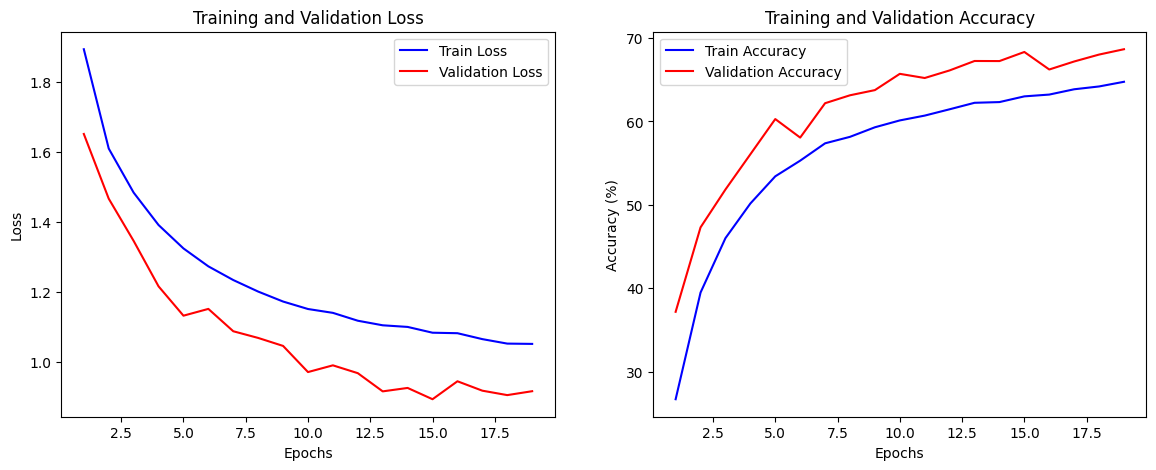

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

plot_training_history(train_loss, val_loss, train_acc, val_acc)

Confusion Matrix


Test Accuracy: 69.71%


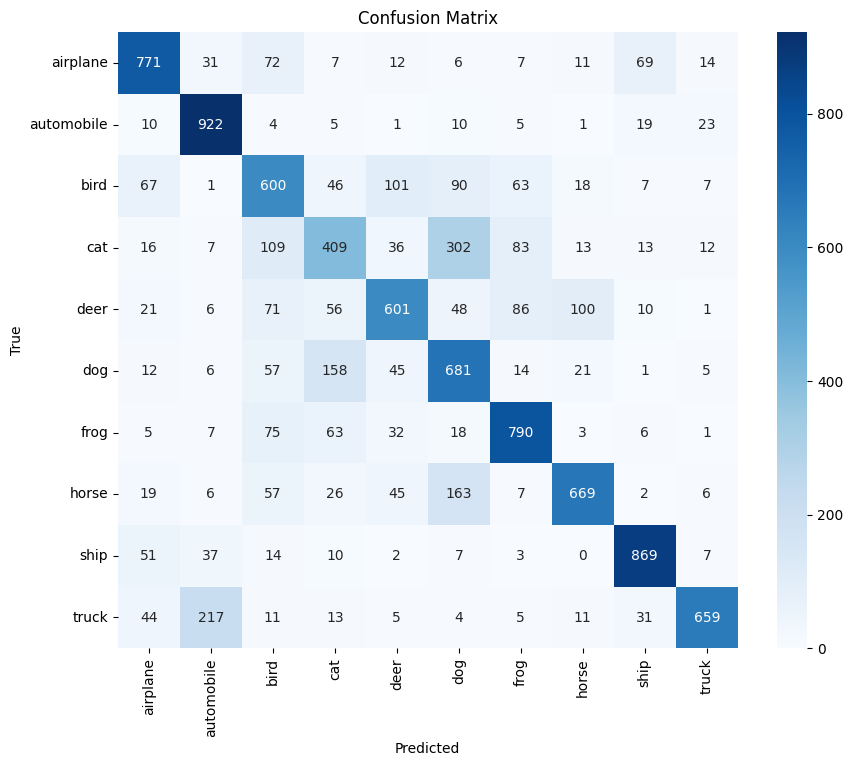

In [12]:
def test_and_confusion(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nTest Accuracy: {acc * 100:.2f}%")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel("Predicted"), plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

test_and_confusion(model, test_loader)


ROC AND AUC CURVE and precision and recall for every class


Class-wise Precision, Recall and F1-Score:
airplane: Precision=0.759, Recall=0.771, F1-score=0.765
automobile: Precision=0.744, Recall=0.922, F1-score=0.823
bird: Precision=0.561, Recall=0.600, F1-score=0.580
cat: Precision=0.516, Recall=0.409, F1-score=0.456
deer: Precision=0.683, Recall=0.601, F1-score=0.639
dog: Precision=0.512, Recall=0.681, F1-score=0.585
frog: Precision=0.743, Recall=0.790, F1-score=0.766
horse: Precision=0.790, Recall=0.669, F1-score=0.724
ship: Precision=0.846, Recall=0.869, F1-score=0.857
truck: Precision=0.897, Recall=0.659, F1-score=0.760


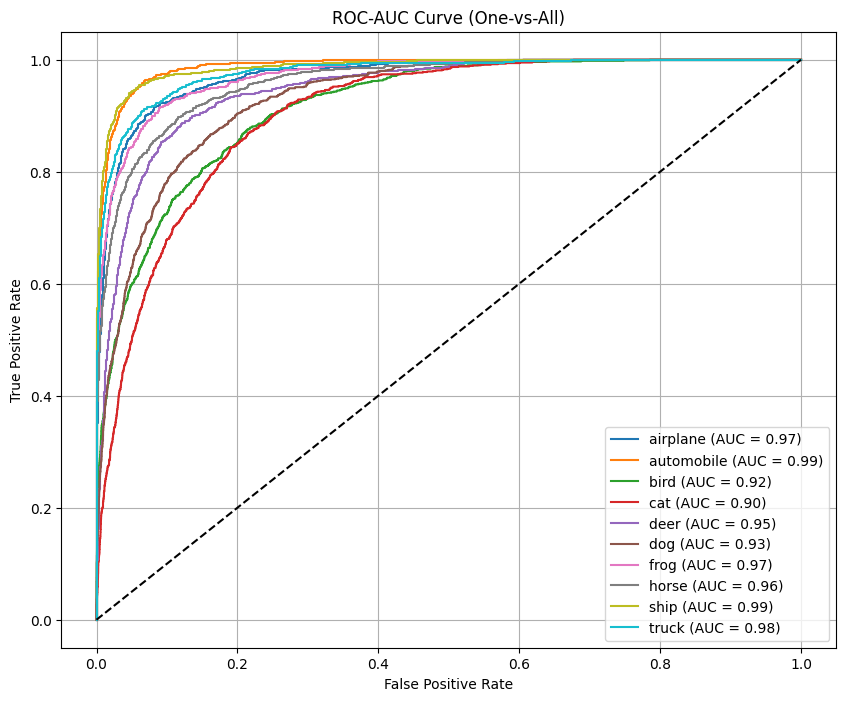

In [13]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def test_metrics_and_roc(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []
    y_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Per-class precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)))

    print("Class-wise Precision, Recall and F1-Score:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={f1[i]:.3f}")

    # ROC-AUC per class (one-vs-all)
    y_true_bin = np.eye(len(class_names))[y_true]  # one-hot encoding

    plt.figure(figsize=(10,8))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # random guess line
    plt.title("ROC-AUC Curve (One-vs-All)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Call it like this:
test_metrics_and_roc(model, test_loader, test_data.classes)


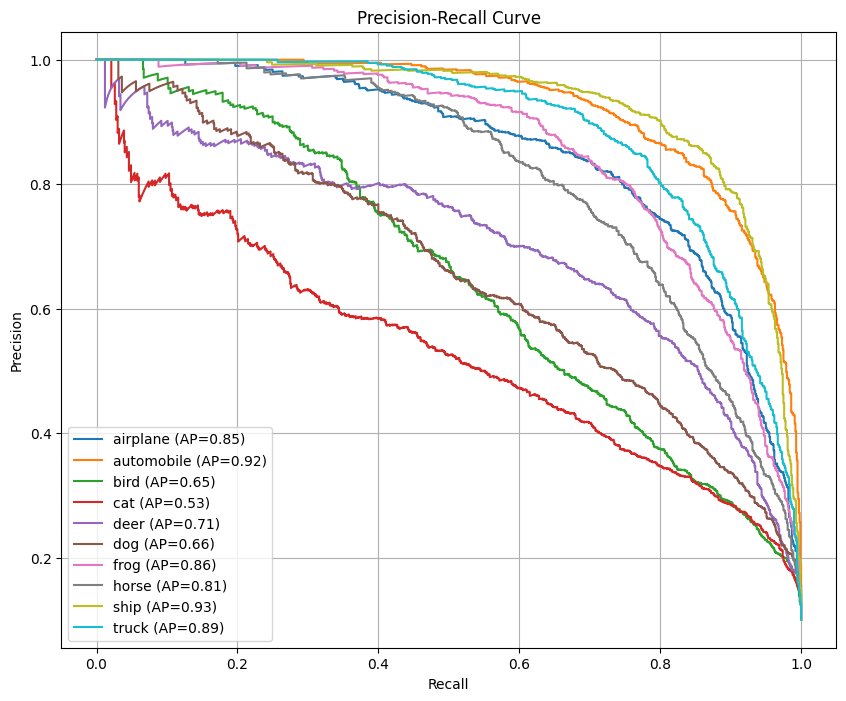

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, data_loader, class_names, device):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_true_bin = np.eye(len(class_names))[y_true]  # One-hot encoding

    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(class_names):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap_score = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall_curve, precision_curve, label=f"{cls} (AP={ap_score:.2f})")

    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

# Usage:
# plot_precision_recall_curve(model, test_loader, test_data.classes, device)
plot_precision_recall_curve(model, test_loader, test_data.classes, device)